# Definitions

In [1]:
%matplotlib widget

In [2]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import mplcursors
import IPython
import os
from PIL import Image, ImageFilter
from scipy.ndimage import gaussian_filter

In [3]:
dest = '../../data/2nd Semester/images/Greece/'

In [4]:
lst_day_destination = dest+ "lst year 2023/Day/"
lst_night_destination = dest+ "lst year 2023/Night/"
ndvi_destination = dest + "ndvi year 2023/"
evi_destination = dest + "evi year 2023/"

In [5]:
class box:
    def __init__(self):
        self.bottom = 0
        self.top = 0
        self.right = 0
        self.left = 0

    def print(self, endl=""):
        print("bottom =", self.bottom)
        print("left =", self.left)
        print("top =", self.top)
        print("right =", self.right, endl)

In [20]:
class image_data:
    def __init__(self):
        self.pixels = None
        self.title = None
        self.__bounds = None
        self.__transform = None
        self.__real_bounds = None
        self.blur_radius = None

    def load(self, array, scale, offset, mask_min, mask_max, title):
        self.title = title
        self.pixels = array
        self.pixels *= scale
        self.pixels += offset
        self.__bounds = dataset.bounds
        self.__real_bounds = box()
        self.__transform = dataset.meta['transform']
        
        self.__real_bounds.right, self.__real_bounds.top = rasterio.transform.xy(self.__transform,0 ,self.pixels.shape[1]-1)
        self.__real_bounds.left, self.__real_bounds.bottom = rasterio.transform.xy(self.__transform, self.pixels.shape[0]-1, 0)
        
        for x in range(self.pixels.shape[0]):
            for y in range(self.pixels.shape[1]):
                if self.pixels[x,y] < mask_min or self.pixels[x,y] > mask_max:
                    self.pixels[x,y] = float("nan")
                    
        self.blur_radius = 6
                    

    def getxy(self, row, col):
        if row >=0 and row < self.pixels.shape[1] and col >= 0 and col < self.pixels.shape[0]:
            return rasterio.transform.xy(self.__transform, row , col)
        else:
            print("ROW COL NOT IN BOUNDS")
            return (0,0)
            
    
        
    def getrowcol(self, x, y):
        return rasterio.transform.rowcol(self.__transform, x , y)

    def map(self, other_image, row, col):
        x, y = rasterio.transform.xy(self.__transform, row ,col)
        return rasterio.transform.rowcol(other_image.__transform, x , y)
        
    @property
    def size(self):
        return self.pixels.size
        
    @property
    def bounds(self):
        return self.__real_bounds

In [7]:
def nan_gaussian_filter(arr, sigma):
    mask = np.isfinite(arr).astype(float)
    
    arr_temp = np.nan_to_num(arr, nan=0)
    
    filtered_arr = gaussian_filter(arr_temp, sigma=sigma)
    filtered_mask = gaussian_filter(mask, sigma=sigma)
    
    with np.errstate(invalid='ignore', divide='ignore'):
        result = filtered_arr / filtered_mask
        result[filtered_mask == 0] = np.nan 
    
    result[np.isnan(arr)] = np.nan
    
    return result

In [8]:
def average_images_ignore_nan(image_list):
    sum_array = np.zeros_like(image_list[0].pixels)
    count_array = np.zeros_like(image_list[0].pixels, dtype=int)
    result = image_data()
    for img in image_list:
        valid_mask = np.isfinite(img.pixels)  
        sum_array[valid_mask] += img.pixels[valid_mask]
        count_array[valid_mask] += 1


    with np.errstate(invalid='ignore', divide='ignore'):
        average_array = sum_array / count_array
    
    average_array[count_array == 0] = np.nan

    result.load(average_array, 1.0, 0.0, -10000, 10000, image_list[0].title)
    
    return result

In [9]:
def std_images_ignore_nan(image_list, mean_array):
    sum_squares_array = np.zeros_like(image_list[0].pixels)
    count_array = np.zeros_like(image_list[0].pixels, dtype=int)
    result = image_data()
    for img in image_list:
        valid_mask = np.isfinite(img.pixels)
        sum_squares_array[valid_mask] += img.pixels[valid_mask] ** 2
        count_array[valid_mask] += 1

    with np.errstate(invalid='ignore', divide='ignore'):
        variance_array = np.divide(sum_squares_array, count_array, out=np.zeros_like(sum_squares_array, dtype=float), where=count_array!=0) - (mean_array ** 2)

    variance_array[count_array == 0] = np.nan
    
    result.load(np.sqrt(variance_array), 1.0, 0.0, -10000, 10000, image_list[0].title)

    return result

In [10]:
def normalize(array):
    min = np.nanmin(array)
    max = np.nanmax(array)
    return (array-min)/(max-min)

# Temporal Variance

In [11]:
# Loading Images
lst_day_list = []

file_names = os.listdir(lst_day_destination)
for n in file_names:
    with rasterio.open(lst_day_destination+n) as dataset:
        temp = image_data()
        temp.load(dataset.read(1).astype(float), 0.02, -273.15, -200.0, 200.0, "LST")
        lst_day_list.append(temp)

In [12]:
lst_night_list = []

file_names = os.listdir(lst_night_destination)
for n in file_names:
    with rasterio.open(lst_night_destination+n) as dataset:
        temp = image_data()
        temp.load(dataset.read(1).astype(float), 0.02, -273.15, -200.0, 200.0, "LST")
        lst_night_list.append(temp)

In [13]:
ndvi_list = []

file_names = os.listdir(ndvi_destination)
for n in file_names:
    with rasterio.open(ndvi_destination+n) as dataset:
        temp = image_data()
        temp.load(dataset.read(1).astype(float), 1e-4,0,0.0001,1, "NDVI")
        temp.pixels = 25-8.8*temp.pixels
        ndvi_list.append(temp)

In [14]:
lst_list = lst_day_list + lst_night_list

In [15]:
# Getting the average
day_lst_average = average_images_ignore_nan(lst_day_list)
night_lst_average = average_images_ignore_nan(lst_night_list)
ndvi_average = average_images_ignore_nan(ndvi_list)
lst_average = average_images_ignore_nan(lst_list)

In [16]:
# Getting Variance
day_lst_std = std_images_ignore_nan(lst_day_list, day_lst_average.pixels)
night_lst_std = std_images_ignore_nan(lst_night_list, night_lst_average.pixels)
ndvi_std = std_images_ignore_nan(ndvi_list, ndvi_average.pixels)
lst_std = std_images_ignore_nan(lst_list, lst_average.pixels)

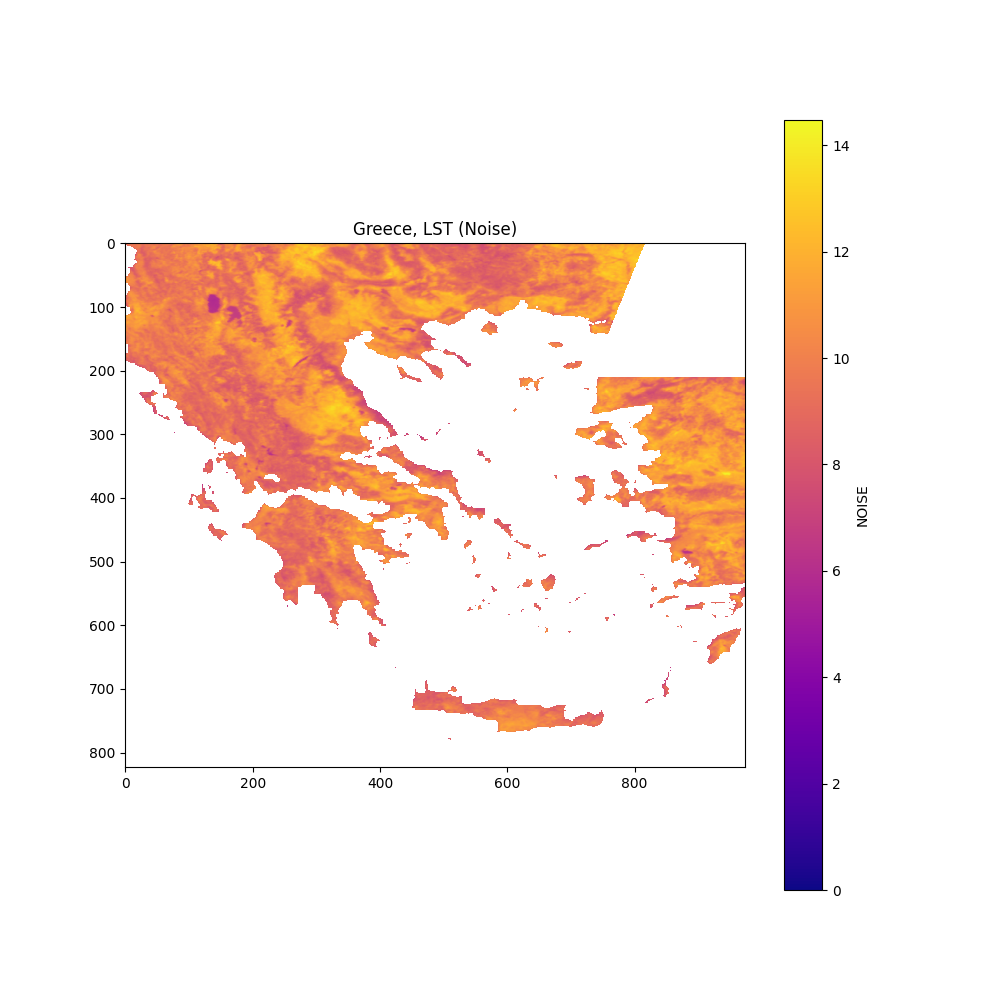

In [17]:
cmap = plt.colormaps['plasma'].copy()  
cmap.set_bad(color='white')

plt.figure(figsize=(10, 10))
plt.imshow(lst_std.pixels, cmap=cmap)
plt.colorbar(label='NOISE')
plt.title('Greece, LST (Noise)')

plt.show()

# Spatial Variance

In [22]:
# loading the images
lst_day = image_data()
dem = image_data()
evi = image_data()
ndvi = image_data()
wp = image_data()

    
with rasterio.open(dest+"day_lst.tif") as dataset:
    lst_day.load(dataset.read(1).astype(float), 0.02, -273.15, -200.0, 200.0, "LST Day")
lst_day.blur_radius = 6

with rasterio.open(dest+"dem.tif") as dataset:
    dem.load(dataset.read(1).astype(float), 1e-4,0,0,5, "DEM")

with rasterio.open(dest+"evi.tif") as dataset:
    evi.load(dataset.read(1).astype(float), 1e-4, 0, 0.00001, 1, "EVI")

with rasterio.open(dest+"ndvi.tif") as dataset:
    ndvi.load(dataset.read(1).astype(float), 1e-4,0,0.0001,1, "NDVI")
ndvi.blur_radius = 3

with rasterio.open(dest+"wp.tif") as dataset:
    wp.load(dataset.read(1).astype(float), 1, 0, 0.00001, 1000000, "Water Proximity")


In [24]:
#Placeholders
main = lst_average
compare = ndvi_average

#Blurring
main_blurred = nan_gaussian_filter(main.pixels, sigma = 6)
compare_blurred = nan_gaussian_filter(compare.pixels, sigma = 6)

#Finding the variance
main_variance = abs(main_blurred - main.pixels)
comp_variance = abs(compare_blurred - compare.pixels)

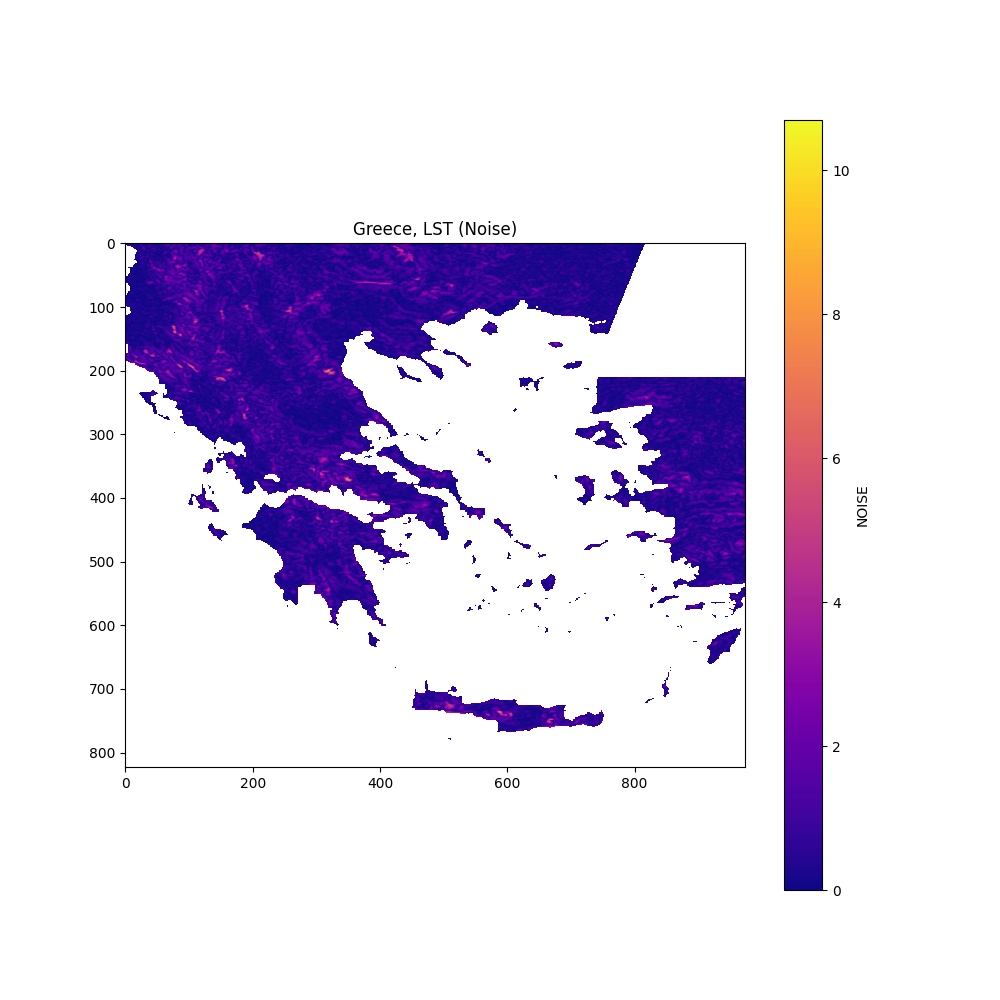

In [25]:
cmap = plt.colormaps['plasma'].copy()  
cmap.set_bad(color='white')

plt.figure(figsize=(10, 10))
plt.imshow(main_variance, cmap=cmap)
plt.colorbar(label='NOISE')
plt.title('Greece, ' + main.title + ' (Noise)')

plt.show()

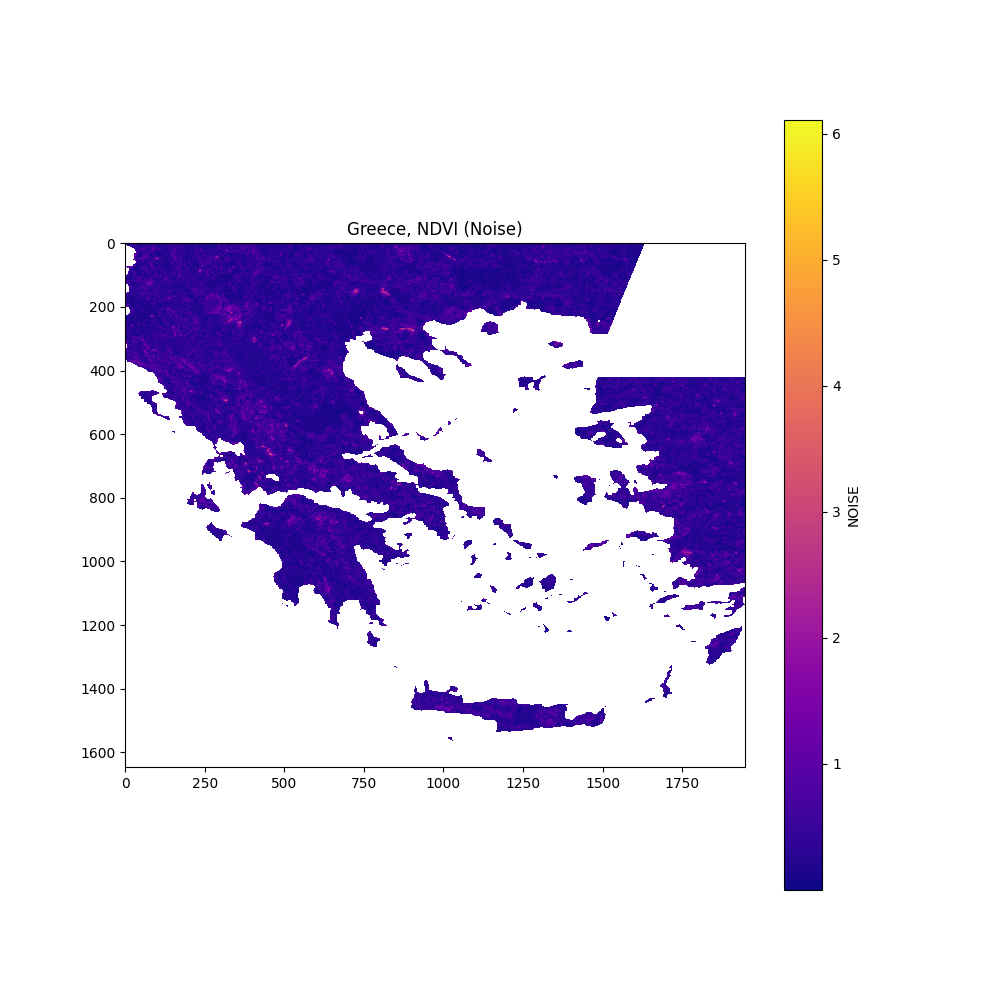

In [26]:
cmap = plt.colormaps['plasma'].copy()  
cmap.set_bad(color='white')

plt.figure(figsize=(10, 10))
plt.imshow(comp_variance, cmap=cmap)
plt.colorbar(label='NOISE')
plt.title('Greece, ' + compare.title + ' (Noise)')

plt.show()

# Cardinality

In [27]:
# Normalizing
day_lst_std.pixels = normalize(day_lst_std.pixels)
night_lst_std.pixels = normalize(night_lst_std.pixels)
ndvi_std.pixels = normalize(ndvi_std.pixels)
lst_std.pixels = normalize(lst_std.pixels)

main_variance = normalize(main_variance)
comp_variance = normalize(comp_variance)

lst_data = lst_std.pixels
aiding_data = ndvi_std.pixels


In [38]:
ndvi_st_noise = ndvi_std.pixels * 0.15 + comp_variance * 0.85
lst_st_noise = lst_std.pixels * 0.5 + main_variance * 0.5

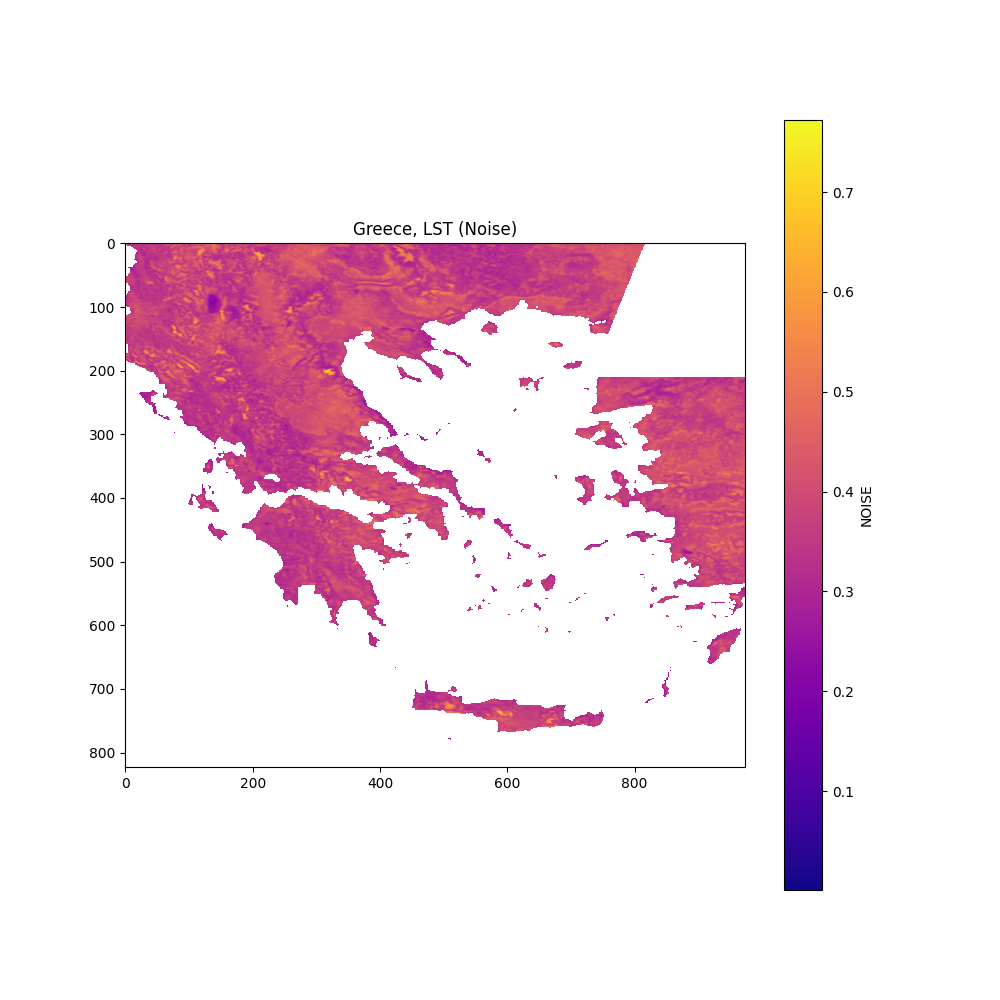

In [40]:
cmap = plt.colormaps['plasma'].copy()  
cmap.set_bad(color='white')

plt.figure(figsize=(10, 10))
plt.imshow(lst_st_noise, cmap=cmap)
plt.colorbar(label='NOISE')
plt.title('Greece, LST (Noise)')

plt.show()

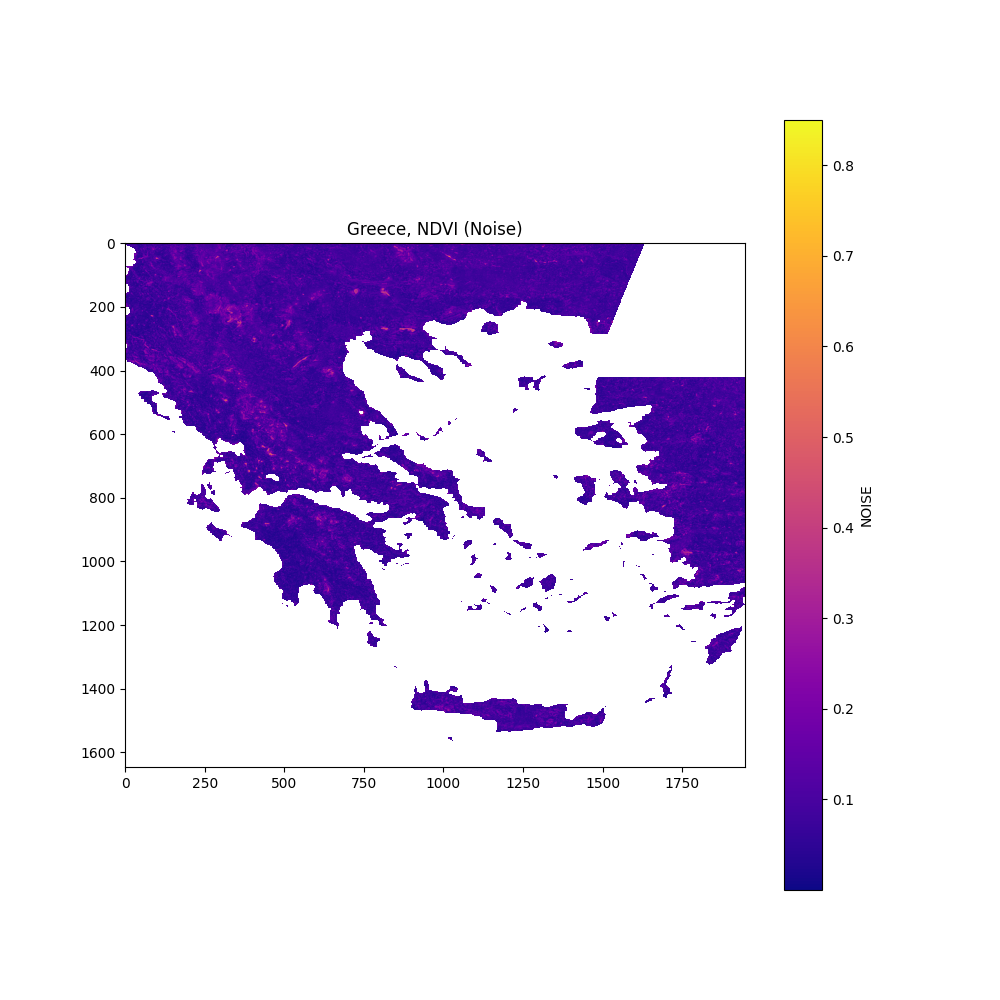

In [30]:
cmap = plt.colormaps['plasma'].copy()  
cmap.set_bad(color='white')

plt.figure(figsize=(10, 10))
plt.imshow(ndvi_st_noise, cmap=cmap)
plt.colorbar(label='NOISE')
plt.title('Greece, ' + compare.title + ' (Noise)')

plt.show()

In [31]:
# Sampling
num_samples = 10000

############# LST ###############

valid_mask = ~np.isnan(lst_data)
valid_indices = np.argwhere(valid_mask)
sample_indices = np.random.choice(len(valid_indices), num_samples, replace=False)
samples_lst = np.array([(valid_indices[i][0], valid_indices[i][1], lst_data[valid_indices[i][0], valid_indices[i][1]]) for i in sample_indices])
sv_lst = samples_lst[:,2]

########### AIDING ##############

valid_mask = ~np.isnan(aiding_data)
valid_indices = np.argwhere(valid_mask)
sample_indices = np.random.choice(len(valid_indices), num_samples, replace=False)
samples_aiding = np.array([(valid_indices[i][0], valid_indices[i][1], aiding_data[valid_indices[i][0], valid_indices[i][1]]) for i in sample_indices])
sv_aiding = samples_aiding[:,2]

#################################

# sample -> (x,y,value)

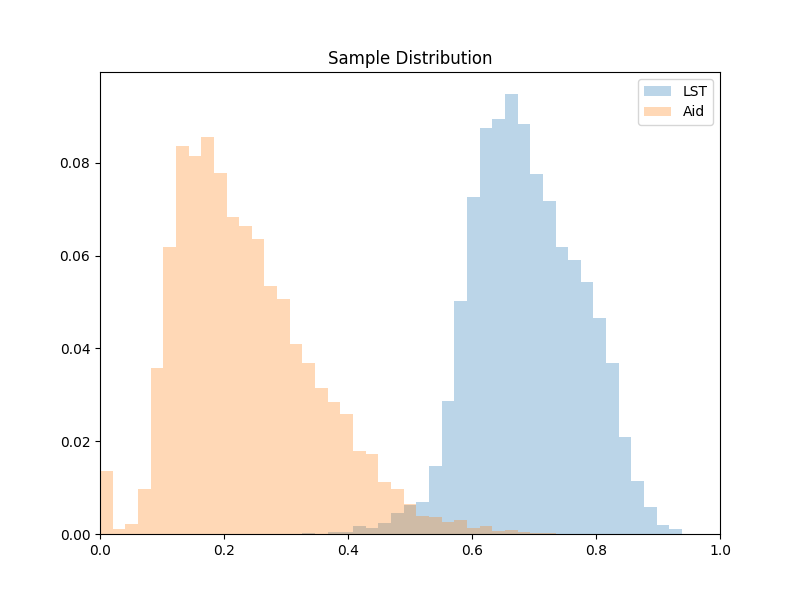

In [32]:
# Creating Pdfs
num_bins = 50
############# LST ###############
bin_edges = np.linspace(0, 1, num = num_bins)
counts, bin_edges = np.histogram(sv_lst, bins=bin_edges)
probabilities1 = counts / len(sv_lst)

def lst_pdf(x):
    bin_index = np.digitize(x, bin_edges) - 1
    if bin_index < 0 or bin_index >= len(probabilities1):
        return 0
    return probabilities1[bin_index]

counts, bin_edges = np.histogram(sv_lst, bins=bin_edges)
probabilities1 = counts / len(sv_lst)

plt.figure(figsize=(8, 6))
plt.hist(sv_lst, bins=bin_edges, weights=np.ones_like(sv_lst) / len(sv_lst), alpha=0.3, label = "LST")
plt.xlim(0, 1)
plt.title('Sample Distribution')


########### AIDING ##############
bin_edges = np.linspace(0, 1, num=num_bins)
counts, bin_edges = np.histogram(sv_aiding, bins=bin_edges)
probabilities2 = counts / len(sv_aiding)

def aiding_pdf(x):
    bin_index = np.digitize(x, bin_edges) - 1
    if bin_index < 0 or bin_index >= len(probabilities2):
        return 0
    return probabilities2[bin_index]

counts, bin_edges = np.histogram(sv_aiding, bins=bin_edges)
probabilities2 = counts / len(sv_aiding)

plt.hist(sv_aiding, bins=bin_edges, weights=np.ones_like(sv_aiding) / len(sv_aiding), alpha=0.3, label = "Aid")
plt.legend(loc='upper right')

###################################
plt.show()

In [33]:
X = np.linspace(0, 1, num = 50)
plt.plot(X,np.vectorize(lst_pdf)(X))
plt.plot(X,np.vectorize(aiding_pdf)(X))

In [34]:
# mixed pdf
def mixed_pdf(x):
    return lst_pdf(x) * 0.7 + aiding_pdf(x) * 0.3

plt.plot(X,np.vectorize(mixed_pdf)(X))

In [35]:
weights = samples_lst.copy()
xy_samples = weights[:,:2]
ssz = len(xy_samples)
weights[:,2] = np.vectorize(mixed_pdf)(weights[:,2])
subsamples = xy_samples[np.random.choice(int(ssz), size=int(ssz/10), p=(weights[:,2]/np.sum(weights[:,2])))]

In [36]:
subsamples

array([[402., 279.],
       [147., 214.],
       [ 95., 478.],
       ...,
       [536., 267.],
       [319., 772.],
       [ 70., 561.]])

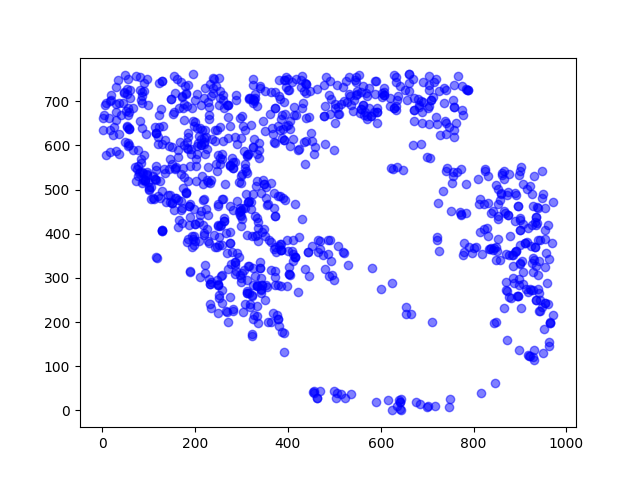

In [37]:
plt.figure()
plt.scatter(subsamples[:,1], np.max(subsamples[:,0])-subsamples[:,0], c='blue', alpha=0.5, label='Sampled points')
plt.show()